# Canny Edge Detector
$p.30 \sim p.53$

1. Gaussian filter
2. Find the intensity gradient of the image

  a. Apply a pair of convolution masks

  ![](https://i.imgur.com/EiYaObX.png)

  b. Find the gradient strength and direction with:

  ![](https://i.imgur.com/U5FEiKe.png)

3. Non-maximum Suppression
4. Thresholding edges
5. Hysteresis: The final step. Canny does use two thresholds (upper and lower):
>If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.

[Canny Edge Detector](https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html)

In [4]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

## Step 1. Gaussian filter

In [5]:
import math
#sigma=0.3∗((ksize−1)∗0.5−1)+0.8
def GaussiaFilter(KernalSize):
    sigma = 0.3*((KernalSize-1)*0.5-1)+0.8
    kernel =[]
    total = 0 #各係數相加後總值
    for i in range(0,KernalSize):
        for j in range(0,KernalSize):
            a = pow(i-(KernalSize-1)/2,2)
            b = pow(j-(KernalSize-1)/2,2)
            g = math.exp(-(a+b) / (2*sigma*sigma))
            g /= 2*math.pi*sigma
            kernel.append(g)
            total += g
    return np.array(kernel)/total        

#row,col,_=img.shape
KernalSize=3
Gaussian_Kernel=GaussiaFilter(KernalSize)
print('Sum of filter :',np.sum(Gaussian_Kernel))
Gaussian_Kernel = np.reshape(Gaussian_Kernel , (3,3))

Sum of filter : 1.0


(402, 715)


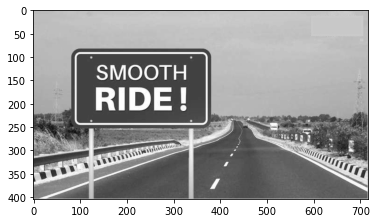

In [6]:
#使用opencv讀取灰階值
#cmap自己設定coloar map 為灰色 因為matpolit 會用預設繪圖
#plt.imshow(img, cmap='gray')
#plt.show()
img = cv2.imread('C:\Highway2.jpg',0)
img_o=cv2.imread('C:\Highway2.jpg',0)
ht, wd= img.shape #(612,1088)
print (img.shape)
ww = ht+2
hh = wd+2
color = img[0][0]
result = np.full((ww,hh),color)
#print (result.shape)
result[1:ww-1, 1:hh-1] = img
plt.imshow(result, cmap='gray')
plt.show()
#增加padding

In [7]:
#Convolution
row,col=img.shape
resx=np.zeros((ww,hh)) #initial a result image
#resx=np.zeros((row-int((KernalSize-1)/2),col-int((KernalSize-1)/2),3),np.uint8) #initial a result image
middle = (KernalSize-1)//2
for x in range(row):
    for y in range(col):
        gg = result[x:x+KernalSize,y:y+KernalSize]*Gaussian_Kernel
        gg = np.sum(gg)
        resx[x+middle,y+middle] = gg

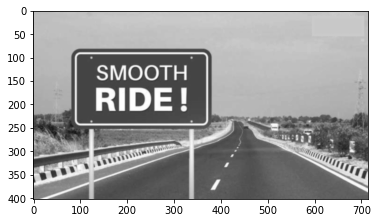

In [8]:
img=np.zeros((row,col,3),np.uint8) #initial a result image
img=resx[0:row,0:col]
plt.imshow(img, cmap='gray')
plt.show()

## Step 2. Filter image with derivative of Gaussian
![](https://i.imgur.com/G4e6Z4n.png)

In [9]:
def sobel(img, filtering_type):
    h, w = img.shape

    horizontal = [1,0,-1,2,0,-2,1,0,-1]
    horizontal = np.reshape(horizontal,(3,3))
    vertical   = [1,2,1,0,0,0,-1,-2,-1]
    vertical   = np.reshape(vertical,(3,3))
    
    Gx = np.zeros((h - 2, w - 2)) 
    Gy = np.zeros((h - 2, w - 2))

    for img_region, i, j in iterate_regions(img, 3):
        if filtering_type == 'dx':
            img_region = img_region*horizontal
            value = np.sum(img_region)
            Gx[i, j] = value
        elif filtering_type == 'dy':
            img_region = img_region*vertical
            value = np.sum(img_region)
            Gy[i, j] = value
        elif filtering_type == 'magnitude':
            img_region_x = img_region*horizontal
            value_x = np.sum(img_region_x)
            img_region_y = img_region*vertical
            value_y = np.sum(img_region_y)
            Gx[i, j] = value_x
            Gy[i, j] = value_y

    gradient = np.sqrt(np.power(Gx,2)+np.power(Gy,2))
    gradient = np.pad(gradient, (1, 1), 'constant')
    angle = np.zeros((h - 2, w - 2))
    for i in range(h-2):
        for j in range(w-2):
            if Gy[i,j]==0 and Gx[i,j]==0:
                angle[i,j] = 0
            elif Gy[i,j]>0 and Gx[i,j]==0:
                angle[i,j] = 1
            elif Gy[i,j]<0 and Gx[i,j]==0:
                angle[i,j] = -1
            else:
                angle[i,j] = np.arctan(Gy[i,j]/Gx[i,j])
    angle = np.pad(angle, (1, 1), 'constant') #為甚麼要pad到1##################################
    output = np.clip(gradient,0,255)          #超越設為255 低於的設為0
    #猜是把負的角度轉回正值 所以才是+=
    angle += math.pi * np.int32(angle < 0)    #看不太懂QQ  #################################### 為什麼只有小於 0會賦值
    return output, angle

## iterator 
def iterate_regions(img, kernel_size):
    h, w = img.shape
    for i in range(h - kernel_size + 1):
        for j in range(w - kernel_size + 1):
            img_region = img[i:(i + kernel_size), j:(j + kernel_size)]
            yield img_region, i, j

In [10]:
sobel_y,_ = sobel(img, 'dy')
sobel_x,_ = sobel(img, 'dx')

In [11]:
sobel_m,angle_m = sobel(img, 'magnitude')

In [12]:
#print(angle_m)

In [13]:
image_list = []
pros_list =[]
image_list.append(img_o)
image_list.append(sobel_x)
image_list.append(sobel_y)
image_list.append(sobel_m)
pros_list.append('Original')
pros_list.append('Horizontal Sobel filter')
pros_list.append('Vertical Sobel filter')
pros_list.append('Gradient amplitude')

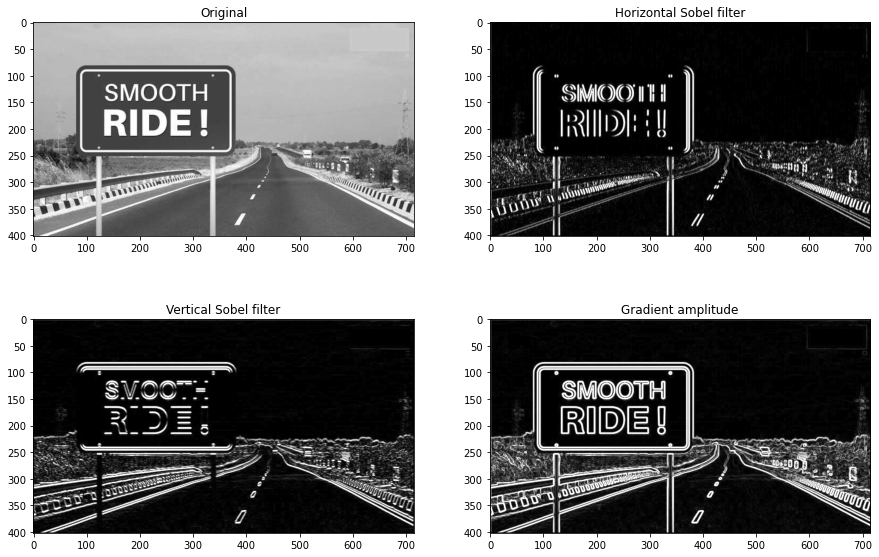

In [14]:
fig = plt.figure(figsize=(15,10))
rows = 2
cols = 2
for i in range(1,5):
    fig.add_subplot(rows,cols,i)
    plt.title(pros_list[i-1])
    plt.imshow(image_list[i-1],cmap='gray')

## Step 3. Non-maximum Suppression

Non maximum suppression without interpolation requires us to divide the 3x3 grid of pixels into 8 sections. Ie. if the gradient direction falls in between the angle -22.5 and 22.5, then we use the pixels that fall between this angle (r and q) as the value to compare with pixel p, see image below.

![](https://i.imgur.com/55DLrWn.png)
* 為了簡化計算，梯度的方向約略分成四種，0度、45度、90度、135度
* Q : 每一個pixel可以簡化成0 45 90 135 其中一個值 利用它來找某個方向的最大值 

In [15]:
pi_22_5=math.pi/8
pi_67_5=3*math.pi/8
pi_112_5=5*math.pi/8
pi_157_5=7*math.pi/8

In [16]:
            # ------------ to do ----------- #
            #0~22.5度，157.5~180度 為 0 度區間
            
            #22.5~67.5度 為 45度區間
           
            #67.5~112.5度 為 90度區間
            
            #112.5~157.5度 為 135度區間

In [17]:
def non_maximum_suppression(gradient,angle):
    gradient_copy = gradient.copy()
    height,width= gradient.shape
    output = np.zeros((height-2,width-2))
    for i in range(1, height-1):                    ##########為什麼要縮小各1pixel 是因為決定maximal嗎??
        for j in range(1, width-1):
            if 0<=angle[i,j]<=pi_22_5 or pi_157_5<angle[i,j]<=math.pi:
                #angle[i,j] = 0
                value = max(gradient_copy[i,j-1],gradient_copy[i,j],gradient_copy[i,j+1])
                gradient_copy[i,j-1] = value if gradient_copy[i,j-1]== value else 0
                gradient_copy[i,j] = value if gradient_copy[i,j]==value else 0
                gradient_copy[i,j+1] = value if gradient_copy[i,j+1]==value else 0
            elif pi_22_5<angle[i,j]<=pi_67_5:
                #angle[i,j] = math.pi/4
                value = max(gradient_copy[i-1,j+1],gradient_copy[i,j],gradient_copy[i+1,j-1])
                gradient_copy[i-1,j+1] = value if gradient_copy[i-1,j+1]== value else 0
                gradient_copy[i,j] = value if gradient_copy[i,j]==value else 0
                gradient_copy[i+1,j-1] = value if gradient_copy[i+1,j-1]==value else 0
            elif pi_67_5<angle[i,j]<=pi_112_5:
                #angle[i,j] = math.pi/2
                value = max(gradient_copy[i-1,j],gradient_copy[i,j],gradient_copy[i+1,j])
                gradient_copy[i-1,j] = value if gradient_copy[i-1,j]== value else 0
                gradient_copy[i,j] = value if gradient_copy[i,j]==value else 0
                gradient_copy[i+1,j] = value if gradient_copy[i+1,j]==value else 0
            elif pi_112_5<angle[i,j]<=pi_157_5:
                #angle[i,j] = math.pi
                value = max(gradient_copy[i-1,j-1],gradient_copy[i,j],gradient_copy[i+1,j+1])
                gradient_copy[i-1,j-1] = value if gradient_copy[i-1,j-1]== value else 0
                gradient_copy[i,j] = value if gradient_copy[i,j]==value else 0
                gradient_copy[i+1,j+1] = value if gradient_copy[i+1,j+1]==value else 0
    output = gradient_copy
    return output

In [18]:
gradient,angle = sobel(img, 'magnitude')
After_non_maximum_supression = non_maximum_suppression(gradient,angle)

In [19]:
np.max(After_non_maximum_supression)

255.0

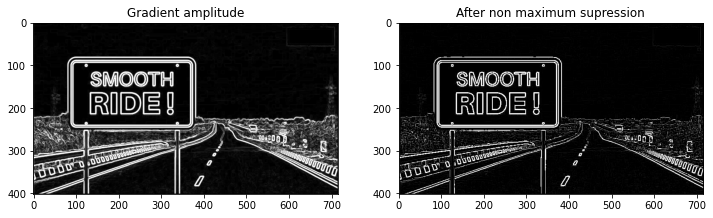

In [20]:
''' 
plt.imshow(gradient,cmap='gray')
plt.show()
plt.imshow(After_non_maximum_supression,cmap='gray')
plt.show()
'''
fig = plt.figure(figsize=(12,10))
rows = 1
cols = 2
fig.add_subplot(rows,cols,1)
plt.title('Gradient amplitude')
plt.imshow(gradient,cmap='gray')
fig.add_subplot(rows,cols,2)
plt.title('After non maximum supression')
plt.imshow(After_non_maximum_supression,cmap='gray')

## Step 4. Thresholding edges


In [21]:
def seperate(img, minimum, maximum ):
    tmp = img.copy()
    tmp[tmp>=maximum]=255
    tmp[tmp<minimum]=0
    return tmp

In [22]:
thresholding = seperate(After_non_maximum_supression, minimum = 20, maximum = 150) #為甚麼預設 跟實際差那麼多

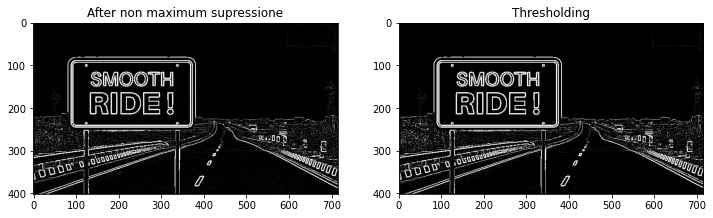

In [23]:
fig = plt.figure(figsize=(12,10))
rows = 1
cols = 2
fig.add_subplot(rows,cols,1)
plt.title('After non maximum supressione')
plt.imshow(After_non_maximum_supression,cmap='gray')
fig.add_subplot(rows,cols,2)
plt.title('Thresholding')
plt.imshow(thresholding,cmap='gray')

## Step 5. Hysteresis
![](https://i.imgur.com/GEu9stb.png)

In [24]:
''' 
def connect(img):
    h,w = img.shape
    for i in range(1,h-1):
        for j in range(1,w-1):
            if 0<img[i,j]<255:
                if img[i-1,j-1]==255:
                    img[i,j]=255
                elif img[i-1,j]==255:
                    img[i,j]=255
                elif img[i-1,j+1]==255:
                    img[i,j]=255
                elif img[i,j-1]==255:
                    img[i,j]=255
                elif img[i,j+1]==255:
                    img[i,j]=255
                elif img[i+1,j-1]==255:
                    img[i,j]=255
                elif img[i+1,j]==255:
                    img[i,j]=255
                elif img[i+1,j+1]==255:
                    img[i,j]=255
                else:
                    img[i,j]=0
    output=np.zeros((h,w))
    output=img
    return output

''' 

' \ndef connect(img):\n    h,w = img.shape\n    for i in range(1,h-1):\n        for j in range(1,w-1):\n            if 0<img[i,j]<255:\n                if img[i-1,j-1]==255:\n                    img[i,j]=255\n                elif img[i-1,j]==255:\n                    img[i,j]=255\n                elif img[i-1,j+1]==255:\n                    img[i,j]=255\n                elif img[i,j-1]==255:\n                    img[i,j]=255\n                elif img[i,j+1]==255:\n                    img[i,j]=255\n                elif img[i+1,j-1]==255:\n                    img[i,j]=255\n                elif img[i+1,j]==255:\n                    img[i,j]=255\n                elif img[i+1,j+1]==255:\n                    img[i,j]=255\n                else:\n                    img[i,j]=0\n    output=np.zeros((h,w))\n    output=img\n    return output\n\n'

In [25]:

def connect(img,x,y):
    i=x
    j=y
    #tmp = img.copy()
    h,w = img.shape
    #print(h,w)
    while(i<h-1):
        while(j<w-1):
            if img[i,j]==255:
                if img[i-1,j-1]>0 and img[i-1,j-1]<255:
                    img[i-1,j-1]=255
                    connect(img,i-1,j-1)
                elif img[i-1,j]>0 and  img[i-1,j]<255:
                    img[i-1,j]=255
                    connect(img,i-1,j)
                elif img[i-1,j+1]>0 and img[i-1,j+1]<255:
                    img[i-1,j+1]=255
                    connect(img,i-1,j+1)
                elif img[i,j-1]>0 and img[i,j-1]<255:
                    img[i,j-1]=255
                    connect(img,i,j-1)
                elif img[i,j+1]>0 and img[i,j+1]<255:
                    img[i,j+1]=255
                    connect(img,i,j+1)
                elif img[i+1,j-1]>0 and  img[i+1,j-1]<255:
                    img[i+1,j-1]=255
                    connect(img,i+1,j-1)
                elif img[i+1,j]>0 and  img[i+1,j]<255:
                    img[i+1,j]=255
                    connect(img,i+1,j)
                elif img[i+1,j+1]>0 and img[i+1,j+1]<255:
                    img[i+1,j+1]=255
                    connect(img,i+1,j+1)
            j+=1
        j=y
        i+=1
    return img

In [26]:
dst_img = thresholding.copy()
dst_img = connect(dst_img,1,1)
dst_img[dst_img<255]=0

In [27]:
image_list = []
pros_list =[]
image_list.append(img_o)
image_list.append(sobel_m)
image_list.append(After_non_maximum_supression)
image_list.append(dst_img)
pros_list.append('Original')
pros_list.append('Gradient amplitude')
pros_list.append('non maximum supression')
pros_list.append('result')

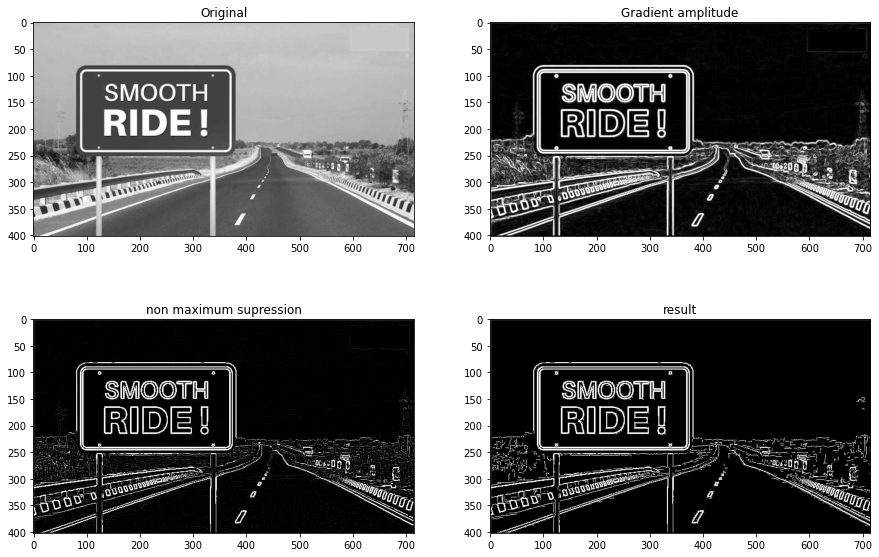

In [28]:
fig = plt.figure(figsize=(15,10))
rows = 2
cols = 2
for i in range(1,5):
    fig.add_subplot(rows,cols,i)
    plt.title(pros_list[i-1])
    plt.imshow(image_list[i-1],cmap='gray')

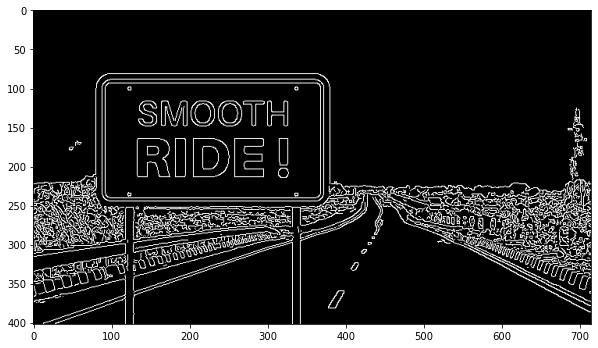

In [29]:
low_threshold = 15
high_threshold = 90
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread('C:\Highway2.jpg',0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()

# PRACTICE(以下為嘗試)

In [402]:
rrr = np.array([[0,0,0,50,70],[0,255,70,0,0],[0,10,50,170,55],[1,0,0,0,0],[0,0,0,0,0],[0,0,1,1,0],[0,255,1,0,0],[1,0,0,0,0]])
print(rrr)
rrr = connect(rrr,1,1)
rrr[1,1]

[[  0   0   0  50  70]
 [  0 255  70   0   0]
 [  0  10  50 170  55]
 [  1   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   1   1   0]
 [  0 255   1   0   0]
 [  1   0   0   0   0]]


255

In [403]:
print(rrr)

[[  0   0   0 255 255]
 [  0 255 255   0   0]
 [  0 255 255 255 255]
 [255   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0 255 255   0]
 [  0 255 255   0   0]
 [255   0   0   0   0]]


In [126]:
img_region = img[0:(0 + 3), 0:(3)]
print(img_region)
print(horizontal)
img_region = img_region*horizontal
print(img_region)


[[  0.   0.   0.]
 [  0. 187. 187.]
 [  0. 187. 187.]]
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
[[   0.    0.   -0.]
 [   0.    0. -374.]
 [   0.    0. -187.]]


In [36]:
a = [1,2,3,5,6,6]
b = [4,5,7,9,8,7]
c = np.power(a,2)+np.power(b,2)
print(c)
d = np.sqrt(c)
d = np.int_(d)
print(d)

[ 17  29  58 106 100  85]
[ 4  5  7 10 10  9]


In [47]:
print(np.arctan(1/1)*180/3.14)

45.022824653356906


In [128]:
    angel = np.zeros((row,col))

In [137]:
angle = 0.5
angle=math.pi * np.int32(angle > 0.5)
print(angle)

0.0


In [206]:
angle =[1,0,0.5,0.4,0.3,-0.1,0.4,-0.8,-1]
angle = np.reshape(angle,(3,3))
print(angle)

[[ 1.   0.   0.5]
 [ 0.4  0.3 -0.1]
 [ 0.4 -0.8 -1. ]]


In [257]:
ccc = np.where(angle>0.2)
print(ccc)

(array([  1,   1,   1, ..., 400, 400, 400], dtype=int64), array([ 31,  32,  33, ..., 711, 712, 713], dtype=int64))


In [173]:
output = np.zeros((3,3))
print(output)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [207]:
angle += math.pi * np.int32(angle < 0)
print(angle)

[[1.         0.         0.5       ]
 [0.4        0.3        3.04159265]
 [0.4        2.34159265 2.14159265]]


In [164]:
a=1
if 0<a<0.5:
    print("DUCK")

In [363]:
a = np.array([[1,5,3],[4,3,1],[7,7,7]])
i,j = np.unravel_index(a.argmax(), a.shape)
print(a[2,2])
e = max(a[1,1],a[2,2],a[0,0])
a[1,1] = e if a[1,1]==e else 0
a[2,2] = e if a[2,2]==e else 0
a[0,0] = e if a[0,0]==e else 0
print(a[1,2])

7
1


In [308]:
def thisisduck(x,y):
    i = x 
    j = y
    while(i<=10):
        while(j<=10):
            print(i,j)
            j+=1
        j=y
        i+=1
        

In [309]:
thisisduck(4,4)

4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 4
10 5
10 6
10 7
10 8
10 9
10 10
